In [2]:
require(data.table)
require(dplyr)
require(tidyverse)
require(phyloseq)
require(DESeq2)
require(ggplot2)
require(vegan)
require(RColorBrewer)
require(metacoder)
options(repr.plot.width=20, repr.plot.height=15)

### DESeq2 test results

In [3]:
res<- readRDS("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/RDS/res_dds.rds")

In [4]:
head(res)

log2 fold change (MLE): Cluster 2 vs 1 
Wald test p-value: Cluster 2 vs 1 
DataFrame with 6 rows and 6 columns
       baseMean log2FoldChange     lfcSE      stat      pvalue        padj
      <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
ASV1   1069.296       -7.49343   1.17619  -6.37092 1.87892e-10 4.95466e-09
ASV3   1704.947       -8.74122   1.24825  -7.00280 2.50890e-12 6.96837e-11
ASV5    300.488       -9.08546   1.56753  -5.79603 6.79039e-09 1.65534e-07
ASV8    132.478        6.40397   1.57537   4.06505 4.80220e-05 8.07556e-04
ASV9   2118.720      -10.33846   1.42735  -7.24312 4.38479e-13 1.23815e-11
ASV10    51.916       -3.95480   1.85751  -2.12908 3.32474e-02 1.93746e-01

In [5]:
res_df <- as.data.frame(res)
res_df$EnrichedIn <- ifelse(res_df$log2FoldChange > 0, "Cluster2", "Cluster1")
class(res_df)

[1] "data.frame"

In [6]:
nrow(res_df)
length(res_df$EnrichedIn)
table(res_df$EnrichedIn)

[1] 6787

[1] 6787


Cluster1 Cluster2 
    4557     2230 

#### ^ making a new df from res with a new column IDing cluster 1 and cluster 2, based on logFC
- fold change is the ratio between the two groups
- FC= (Expression of X in grp2)/(expression of X in grp 1)
- FC=2 logFC=1
- FC=4 logFC=2
- FC=.5 logFC=-1

### DESeq2 volcano
- most statistically significant asvs will be towards the top bc they have the lowest p-values
- EnhancedVolcano will only attempt to label genes that pass the thresholds that you set for statistical significance, i.e., ‘pCutoff’ and ‘FCcutoff’

In [7]:
library(EnhancedVolcano)

Loading required package: ggrepel



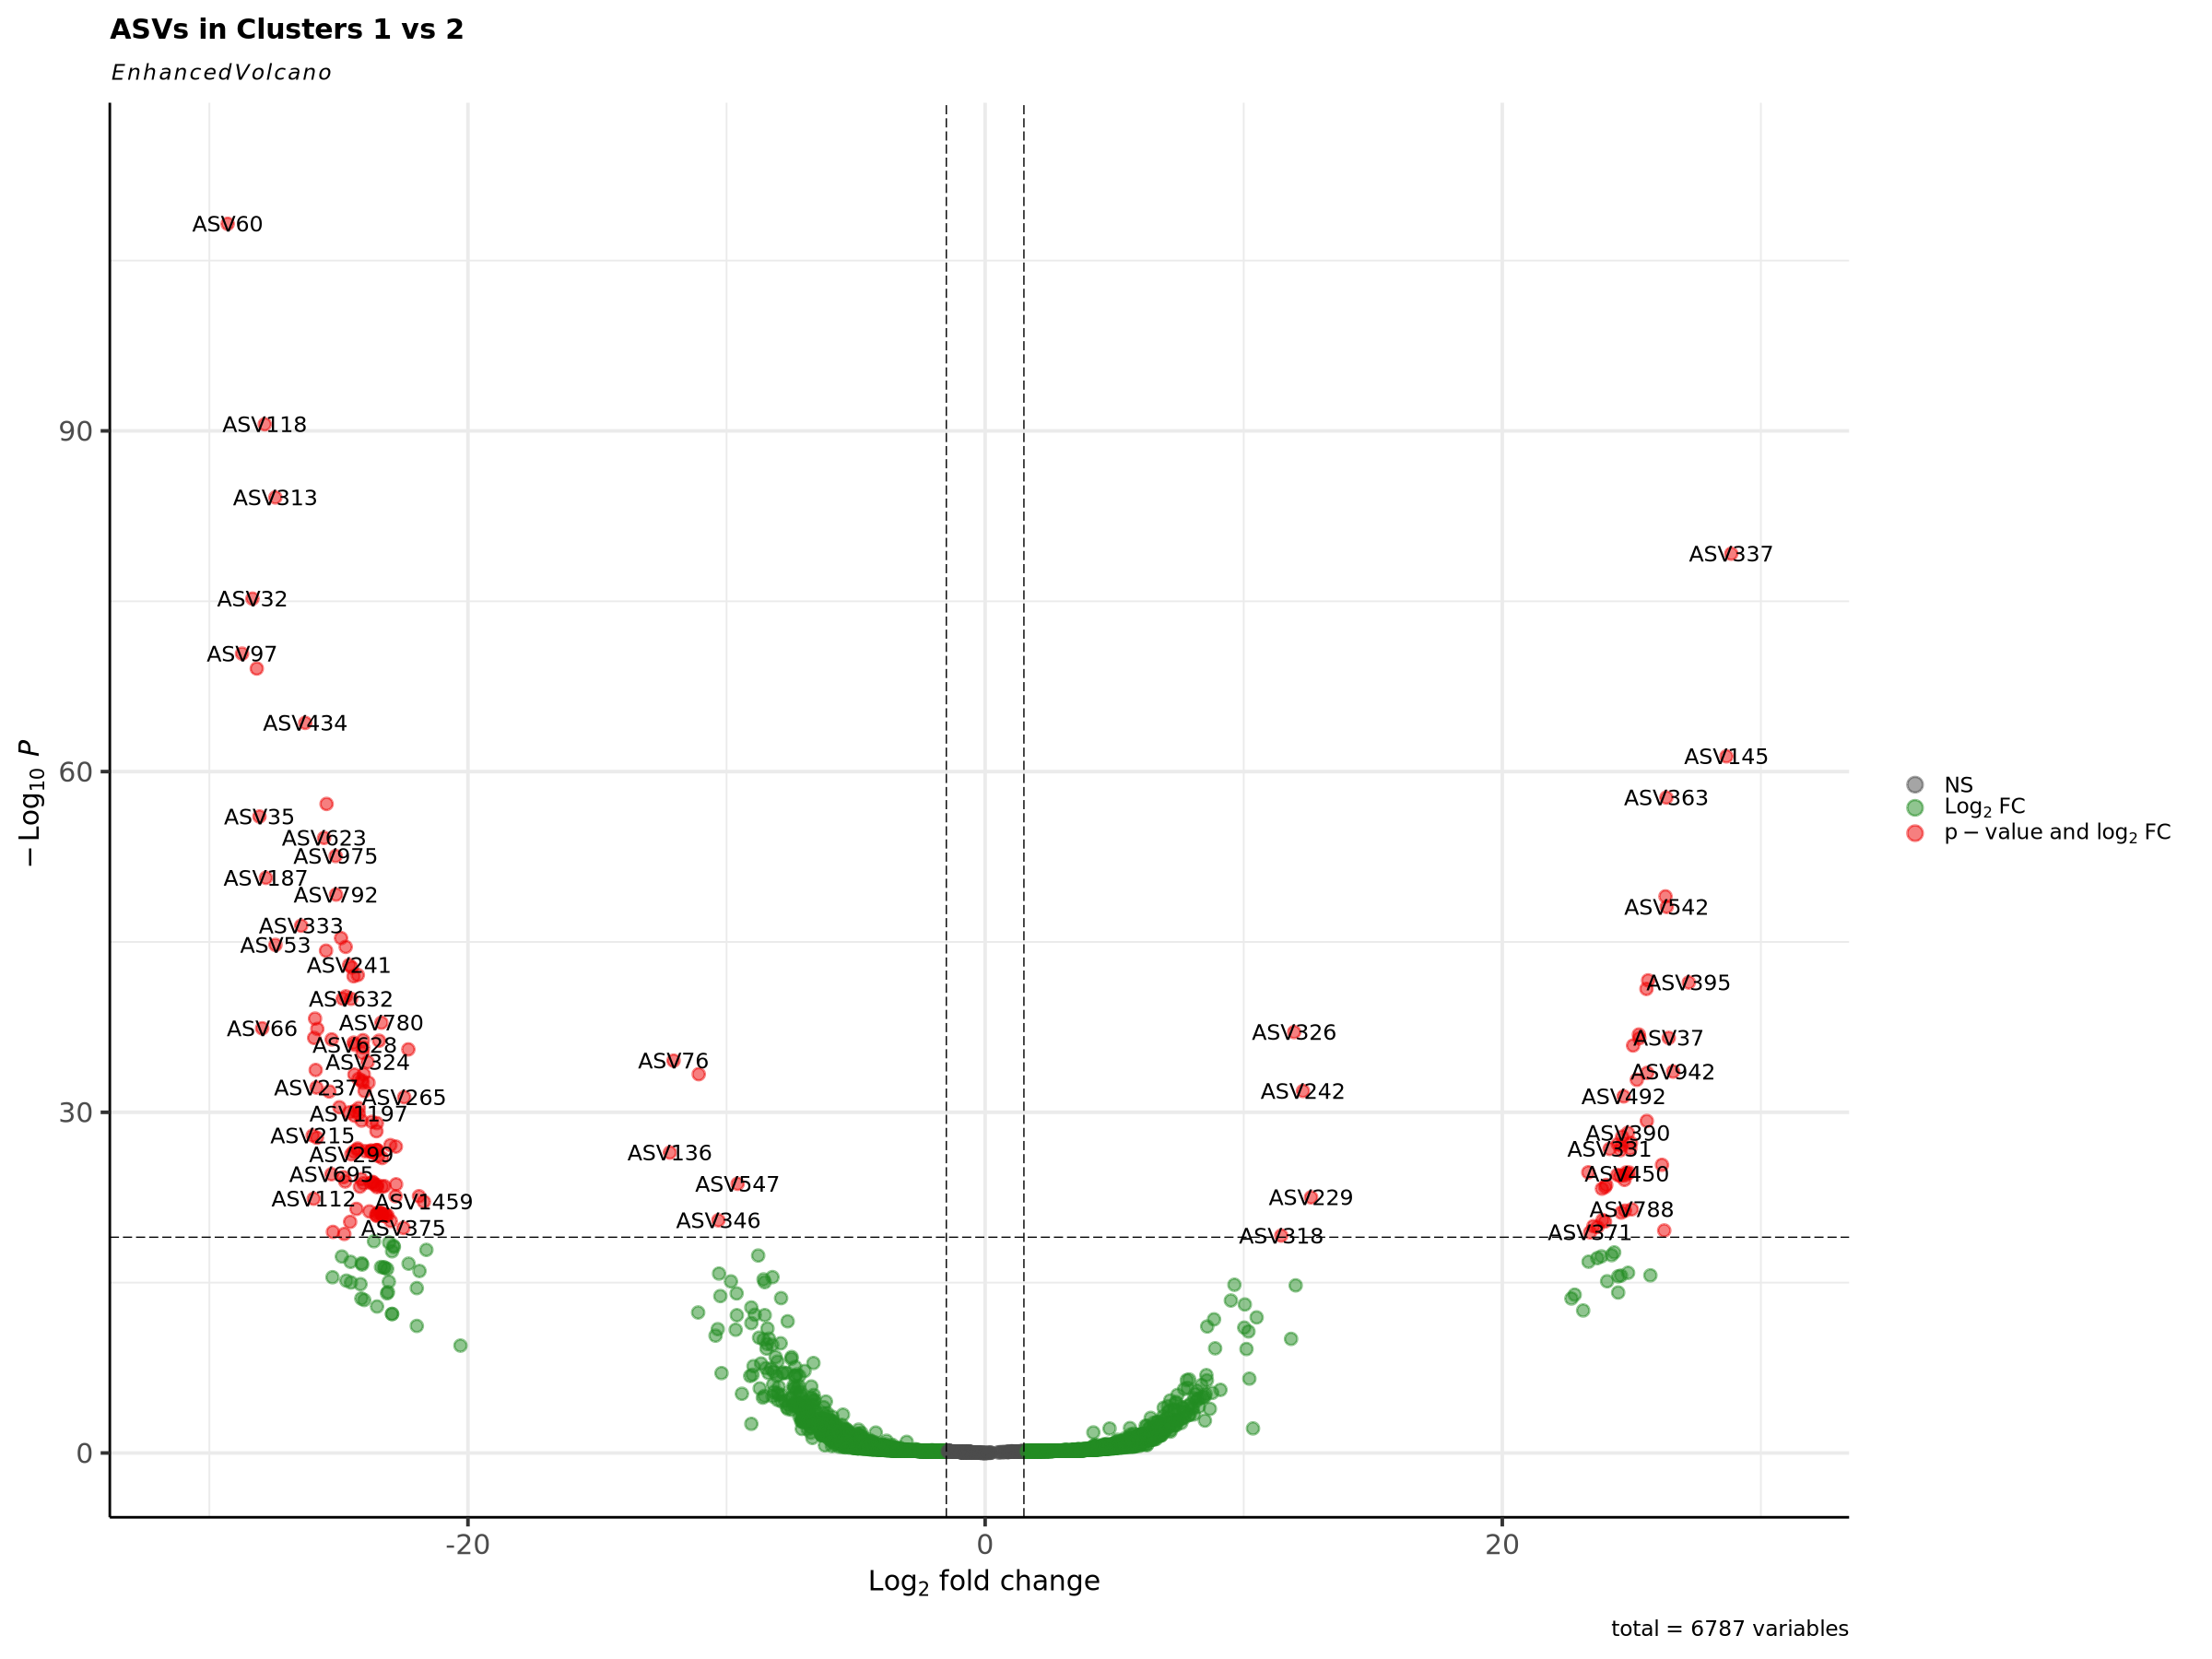

In [9]:
 #first attempt without ASV short names is unreadable
#with ASV short names
#res and sig_cluster look the same
EnhancedVolcano(res_df,
    lab = rownames(res_df),
    x = 'log2FoldChange',
    y = 'padj',
    title = 'ASVs in Clusters 1 vs 2',
    pCutoff =  10e-20, #p value=0.01
    FCcutoff = 1.5,
    pointSize = 3.0,
    legendPosition = 'right',
    legendLabSize = 14,
    legendIconSize = 4.0,)

### interperting volcano plot
- positve LogFC indicates more expression of ASVs in cluster 2
- the higher the -logP the more signifcant

### custom volcano plot

In [8]:
str(res_df$EnrichedIn)      # Should be a character or factor vector, length 6787
unique(res_df$EnrichedIn)   # Should show only "Cluster 1" and "Cluster 2"
any(is.na(res_df$EnrichedIn))  # Should be FALSE

 chr [1:6787] "Cluster1" "Cluster1" "Cluster1" "Cluster2" "Cluster1" ...


[1] "Cluster1" "Cluster2"

[1] FALSE

In [9]:
 # create custom key-value pairs for different cell-types
  # this can be achieved with nested ifelse statements
keyvals.shape <- ifelse(
  res_df$EnrichedIn == "Cluster1", 17,
  ifelse(res_df$EnrichedIn == "Cluster2", 64, 3)
)

keyvals.shape[is.na(keyvals.shape)] <- 3

names(keyvals.shape)[keyvals.shape == 17] <- "Cluster1"
names(keyvals.shape)[keyvals.shape == 64] <- "Cluster2"

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
ℹ The deprecated feature was likely used in the EnhancedVolcano package.
  Please report the issue to the authors.”
Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.
ℹ The deprecated feature was likely used in the EnhancedVolcano package.
  Please report the issue to the authors.”


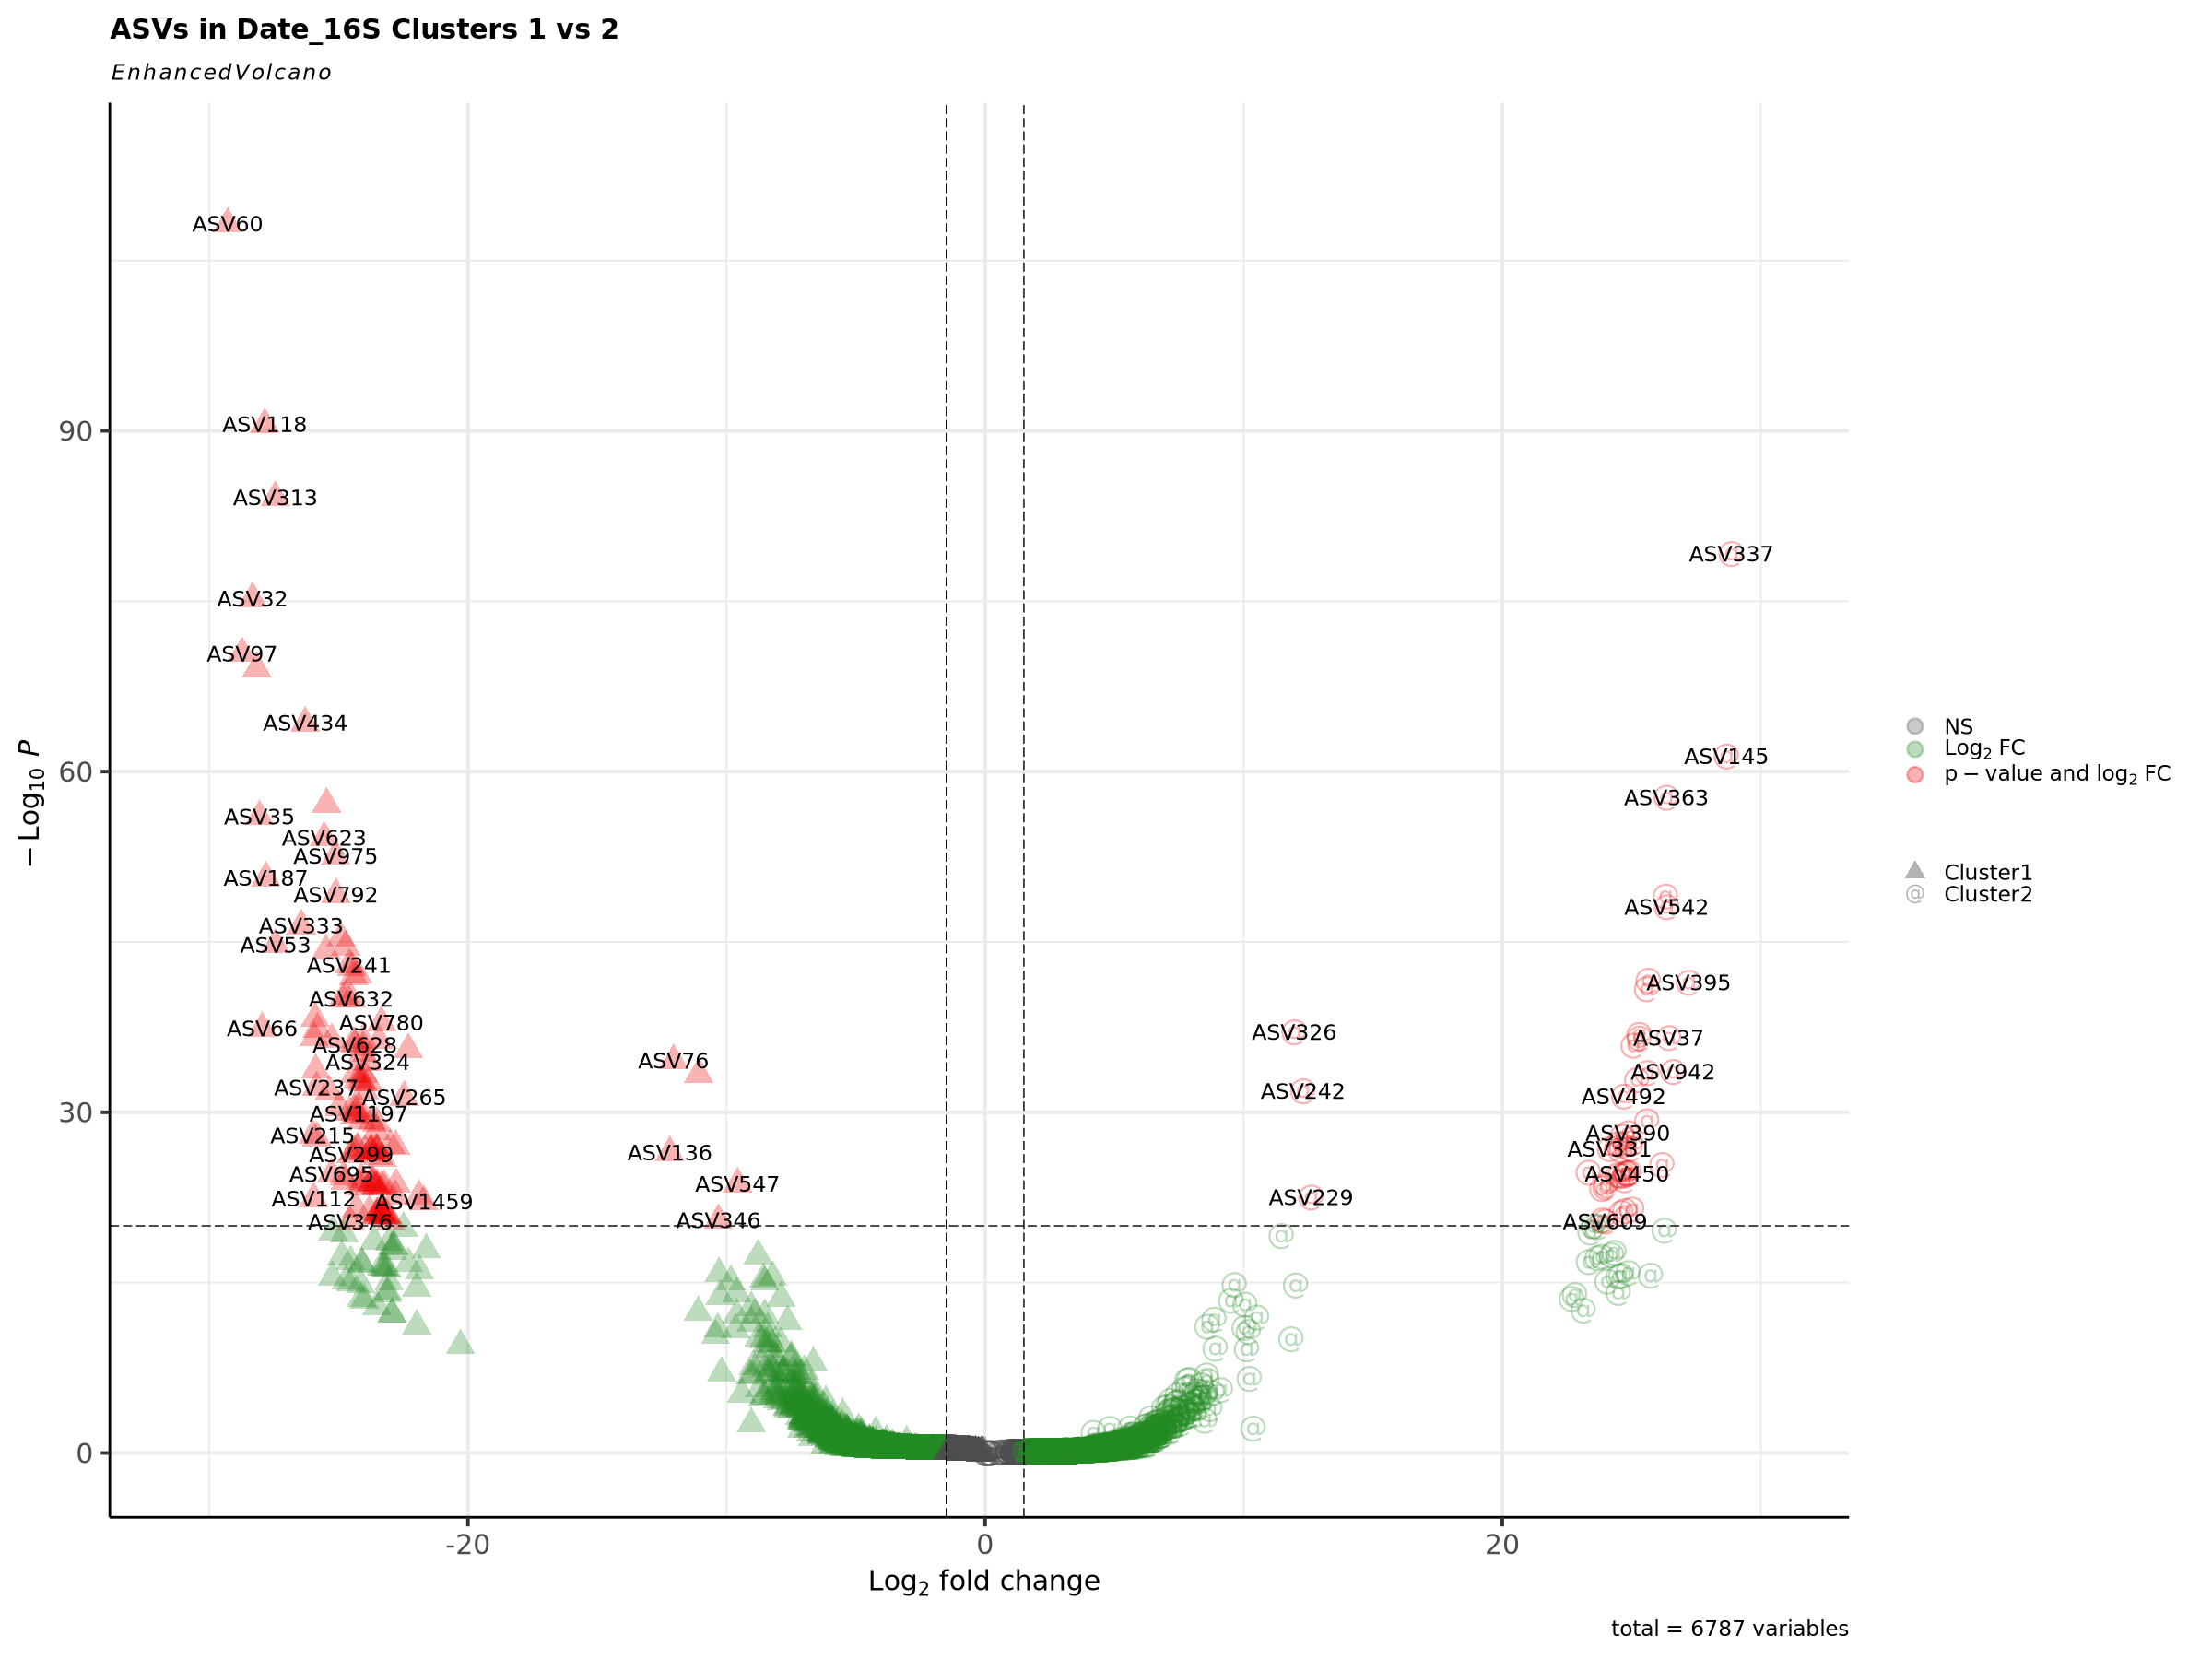

In [10]:
# Step 4: Volcano plot
EnhancedVolcano(res_df,
    lab = rownames(res_df),
    x = 'log2FoldChange',
    y = 'padj',
    title = 'ASVs in Date_16S Clusters 1 vs 2',
    pCutoff = 1e-20,
    FCcutoff = 1.5,
    pointSize = 6.0,
    colAlpha = 0.3,
    legendPosition = 'right',
    legendLabSize = 14,
    legendIconSize = 4.0,
shapeCustom = keyvals.shape,
    colCustom = NULL)

### using significant ASV from volcano plots to find similar taxonomy

In [26]:
asv_map<- readRDS("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/RDS/asv_map.rds")

In [28]:
# Set rownames
rownames(asv_map) <- asv_map$ASV 
asv_map$ASV <- NULL  

In [30]:
head(asv_map)
colnames(asv_map)

,Sequence
,<chr>
ASV1,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG
ASV2,ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA
ASV3,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG
ASV4,ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGCTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA
ASV5,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGGGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG
ASV6,TACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGG


[1] "Sequence"

In [32]:
sig_asvs<- res_df[res_df$pvalue < 1e-20, ]
head(sig_asvs)
NROW(sig_asvs)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,EnrichedIn
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ASV32,364.84983,-28.33487,1.504846,-18.82908,4.362912e-79,5.913491e-76,Cluster1
ASV35,305.62301,-28.06260,1.724735,-16.27067,1.594044e-59,9.002362e-57,Cluster1
ASV37,52.41815,26.43817,2.010479,13.15019,1.697559e-39,2.805941e-37,Cluster2
ASV53,190.40873,-27.44398,1.885789,-14.55305,5.585742e-48,1.802599e-45,Cluster1
ASV60,739.12319,-29.29261,1.297869,-22.56978,8.587731e-113,5.819905e-109,Cluster1
ASV66,278.53180,-27.95882,2.101231,-13.30593,2.138282e-40,4.025316e-38,Cluster1


[1] 172

In [52]:
#inner join
sig_asv_map <- merge(sig_asvs, asv_map, by = "row.names")
#undo the extra column i made 
rownames(sig_asv_map) <- sig_asv_map$Row.names
sig_asv_map$Row.names <- NULL
head(sig_asv_map)
NROW(sig_asv_map)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,EnrichedIn,Sequence
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ASV1003,7.650781,-22.98462,2.339469,-9.824718,8.812021e-23,3.732442e-21,Cluster1,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGCGGTCTGTTAAGCAAGATGTGAAAGCCCGGGGCTCAACCTCGGAACAGCATTTTGAACTGGCAGACTAGAGTCTTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGATGCGAAAGCGTGGGGAGCAAACAGG
ASV1005,31.705462,-23.43799,1.789113,-13.100340,3.277867e-39,4.936468e-37,Cluster1,TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGGCTGTTAAGTCGGGGGTGAAATCCCGGGGCTCAACCCCGGAACTGCCCTCGATACTGGCAGCCTAGAGGTCGAGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGCTCGATACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG
ASV1026,31.391315,-24.97099,2.081713,-11.995401,3.755933e-33,3.585065e-31,Cluster1,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGCGGTCTGGTCAGTCAGATGTGAAAGCCCCGGGCTCAACCTGGGAATTGCATTTGATACTGCCAGACTAGAGTCCTTGAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCAGTGGCGAAGGCGGCCCCCTGGCAAGAGACTGACGCTCAGATGCGAAAGCGTGGGGAGCAAACAGG
ASV1038,28.750833,-24.84196,1.805905,-13.755964,4.689842e-43,9.932206e-41,Cluster1,TACGGAGACTGCGAGCGTTACTCGGATTCACTGGGCGTAAAGGGTGCGCAGGCGGATGAATGTGTCAGGTGTGAAATCTCGGGGCTCAACCTCGAAACTGCGCCTGAAACTGTTCATCTAGAGTATTGGAGAGGTAAGCGGAATTTCCGGTGTAGCGGTGAAATGCGTAGATATCGGAAGGAACACCAATGGCGAAGGCAGCTTACTGGACAACTACTGACGCTCAGGCACGAAAGCATGGGTAGCGAAAGGG
ASV1045,10.825333,-23.51808,2.368776,-9.928367,3.133462e-23,1.361248e-21,Cluster1,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGCGGTCTGTTAAGCAAGATGTGAAAGCCCGGGGCTTAACCTCGGAACAGCATTTTGAACTGGCAGGCTAGAGTCTTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGATGCGAAAGCGTGGGGAGCAAACAGG
ASV1047,27.442441,-22.30533,1.721436,-12.957392,2.133800e-38,2.892153e-36,Cluster1,TACGGGGGGTGCAAGCGTTATTCGGATTTACTGGGCGTAAAGCGCGCGTAGGCGGCCGTTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCCCGGAAGTGCATTTGATACTATTCGGCTTGAGTATGGGAGAGGGAAGTGGAATTCCTGGTGTAGAGGTGAAATTCGTAGATATCAGGAGGAACACCGGTGGCGAAGGCGACTTCCTGGACCAATACTGACGCTGAGGCGCGAAGGCGTGGGGAGCAAACAGG


[1] 172

### comparing sig ASV to taxa in ps_clean

In [53]:
ps<-readRDS(file = "/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/RDS/ps.rds")
#removing any taxa that don't show up in any samples to speed up the process
ps <- prune_taxa(taxa_sums(ps) > 0, ps)

In [54]:
#getting rid of samples in phyloseq with very low-abundance or rarely occurring taxa
    # Remove taxa not seen in at least 3 samples AND total abundance less than 6
    ps <- phyloseq::filter_taxa(ps, function(x) sum(x > 0) > 2 & sum(x) > 5, TRUE)

In [55]:
#isolate just bacteria
ps_bac=subset_taxa(ps, Kingdom=="Bacteria")
#remove chloroplast order
ps_nochlo=subset_taxa(ps_bac, Order!="Chloroplast")
ps_clean=subset_taxa(ps_nochlo, Family!="Mitochondria")

In [56]:
ps_clean

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6787 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95314 sample variables ]
tax_table()   Taxonomy Table:    [ 6787 taxa by 6 taxonomic ranks ]

In [57]:
#make taxa table have an ASV column 
tax_table_df <- as.data.frame(tax_table(ps_clean))
head(tax_table_df)

,Kingdom,Phylum,Class,Order,Family,Genus
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Vibrio
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG,Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales,Endozoicomonadaceae,Parendozoicomonas
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGGGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG,Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales,Endozoicomonadaceae,Parendozoicomonas
ATACGAAGGGAGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTGTAGGCGGATTATCAAGTTAGGGGTGAAATCCCGGGGCTCAACCTCGGCACTGCCTTTAAGACTGATAATCTAGAGTATGTGAGGGGATAATGGAATACCTAGTGTAGAGGTGAAATTCGTAGATATTAGGTGGAACACCAGTGGCGAAGGCGATTATCTGGCACATTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACGGGA,Bacteria,Pseudomonadota,Alphaproteobacteria,Rhodospirillales,Terasakiellaceae,Marivibrio
TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATTGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Vibrio
TACGAAGGGAGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTGTAGGCGGATTATCAAGTTAGGGGTGAAATCCCGGGGCTCAACCTCGGCACTGCCTTTAAGACTGATAATCTAGAGTATGTGAGGGGATAATGGAATACCTAGTGTAGAGGTGAAATTCGTAGATATTAGGTGGAACACCAGTGGCGAAGGCGATTATCTGGCACATTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCGAACGGG,Bacteria,Pseudomonadota,Alphaproteobacteria,Rhodospirillales,Terasakiellaceae,Marivibrio


In [67]:
tax_table_df$Sequence <- row.names(tax_table_df)
#merge asv map and taxonomy table
taxa_sig_asvs <- merge(tax_table_df, sig_asv_map, by = "Sequence", all.x = TRUE)

In [69]:
taxa_sig_asvs <- taxa_sig_asvs[match(sig_asv_map$Sequence, taxa_sig_asvs$Sequence), ]
rownames(taxa_sig_asvs) <- rownames(sig_asv_map)
head(taxa_sig_asvs)

,Sequence,Kingdom,Phylum,Class,Order,Family,Genus,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,EnrichedIn
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ASV1003,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGCGGTCTGTTAAGCAAGATGTGAAAGCCCGGGGCTCAACCTCGGAACAGCATTTTGAACTGGCAGACTAGAGTCTTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGATGCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Photobacterium,7.650781,-22.98462,2.339469,-9.824718,8.812021e-23,3.732442e-21,Cluster1
ASV1005,TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGGCTGTTAAGTCGGGGGTGAAATCCCGGGGCTCAACCCCGGAACTGCCCTCGATACTGGCAGCCTAGAGGTCGAGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGCTCGATACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Pseudomonadota,Alphaproteobacteria,Rhodobacterales,Paracoccaceae,Limibaculum,31.705462,-23.43799,1.789113,-13.100340,3.277867e-39,4.936468e-37,Cluster1
ASV1026,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGCGGTCTGGTCAGTCAGATGTGAAAGCCCCGGGCTCAACCTGGGAATTGCATTTGATACTGCCAGACTAGAGTCCTTGAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCAGTGGCGAAGGCGGCCCCCTGGCAAGAGACTGACGCTCAGATGCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Shewanellaceae,Ferrimonas,31.391315,-24.97099,2.081713,-11.995401,3.755933e-33,3.585065e-31,Cluster1
ASV1038,TACGGAGACTGCGAGCGTTACTCGGATTCACTGGGCGTAAAGGGTGCGCAGGCGGATGAATGTGTCAGGTGTGAAATCTCGGGGCTCAACCTCGAAACTGCGCCTGAAACTGTTCATCTAGAGTATTGGAGAGGTAAGCGGAATTTCCGGTGTAGCGGTGAAATGCGTAGATATCGGAAGGAACACCAATGGCGAAGGCAGCTTACTGGACAACTACTGACGCTCAGGCACGAAAGCATGGGTAGCGAAAGGG,Bacteria,Verrucomicrobiota,Verrucomicrobiia,Opitutales,Puniceicoccaceae,Lentimonas,28.750833,-24.84196,1.805905,-13.755964,4.689842e-43,9.932206e-41,Cluster1
ASV1045,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGCGGTCTGTTAAGCAAGATGTGAAAGCCCGGGGCTTAACCTCGGAACAGCATTTTGAACTGGCAGGCTAGAGTCTTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGATGCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Photobacterium,10.825333,-23.51808,2.368776,-9.928367,3.133462e-23,1.361248e-21,Cluster1
ASV1047,TACGGGGGGTGCAAGCGTTATTCGGATTTACTGGGCGTAAAGCGCGCGTAGGCGGCCGTTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCCCGGAAGTGCATTTGATACTATTCGGCTTGAGTATGGGAGAGGGAAGTGGAATTCCTGGTGTAGAGGTGAAATTCGTAGATATCAGGAGGAACACCGGTGGCGAAGGCGACTTCCTGGACCAATACTGACGCTGAGGCGCGAAGGCGTGGGGAGCAAACAGG,Bacteria,Thermodesulfobacteriota,Desulfobacteria,Desulfobacterales,Desulfosarcinaceae,NA,27.442441,-22.30533,1.721436,-12.957392,2.133800e-38,2.892153e-36,Cluster1


### these are my significant asvs from the volcano plots
- mapped out the taxa
- and the data from deseq2

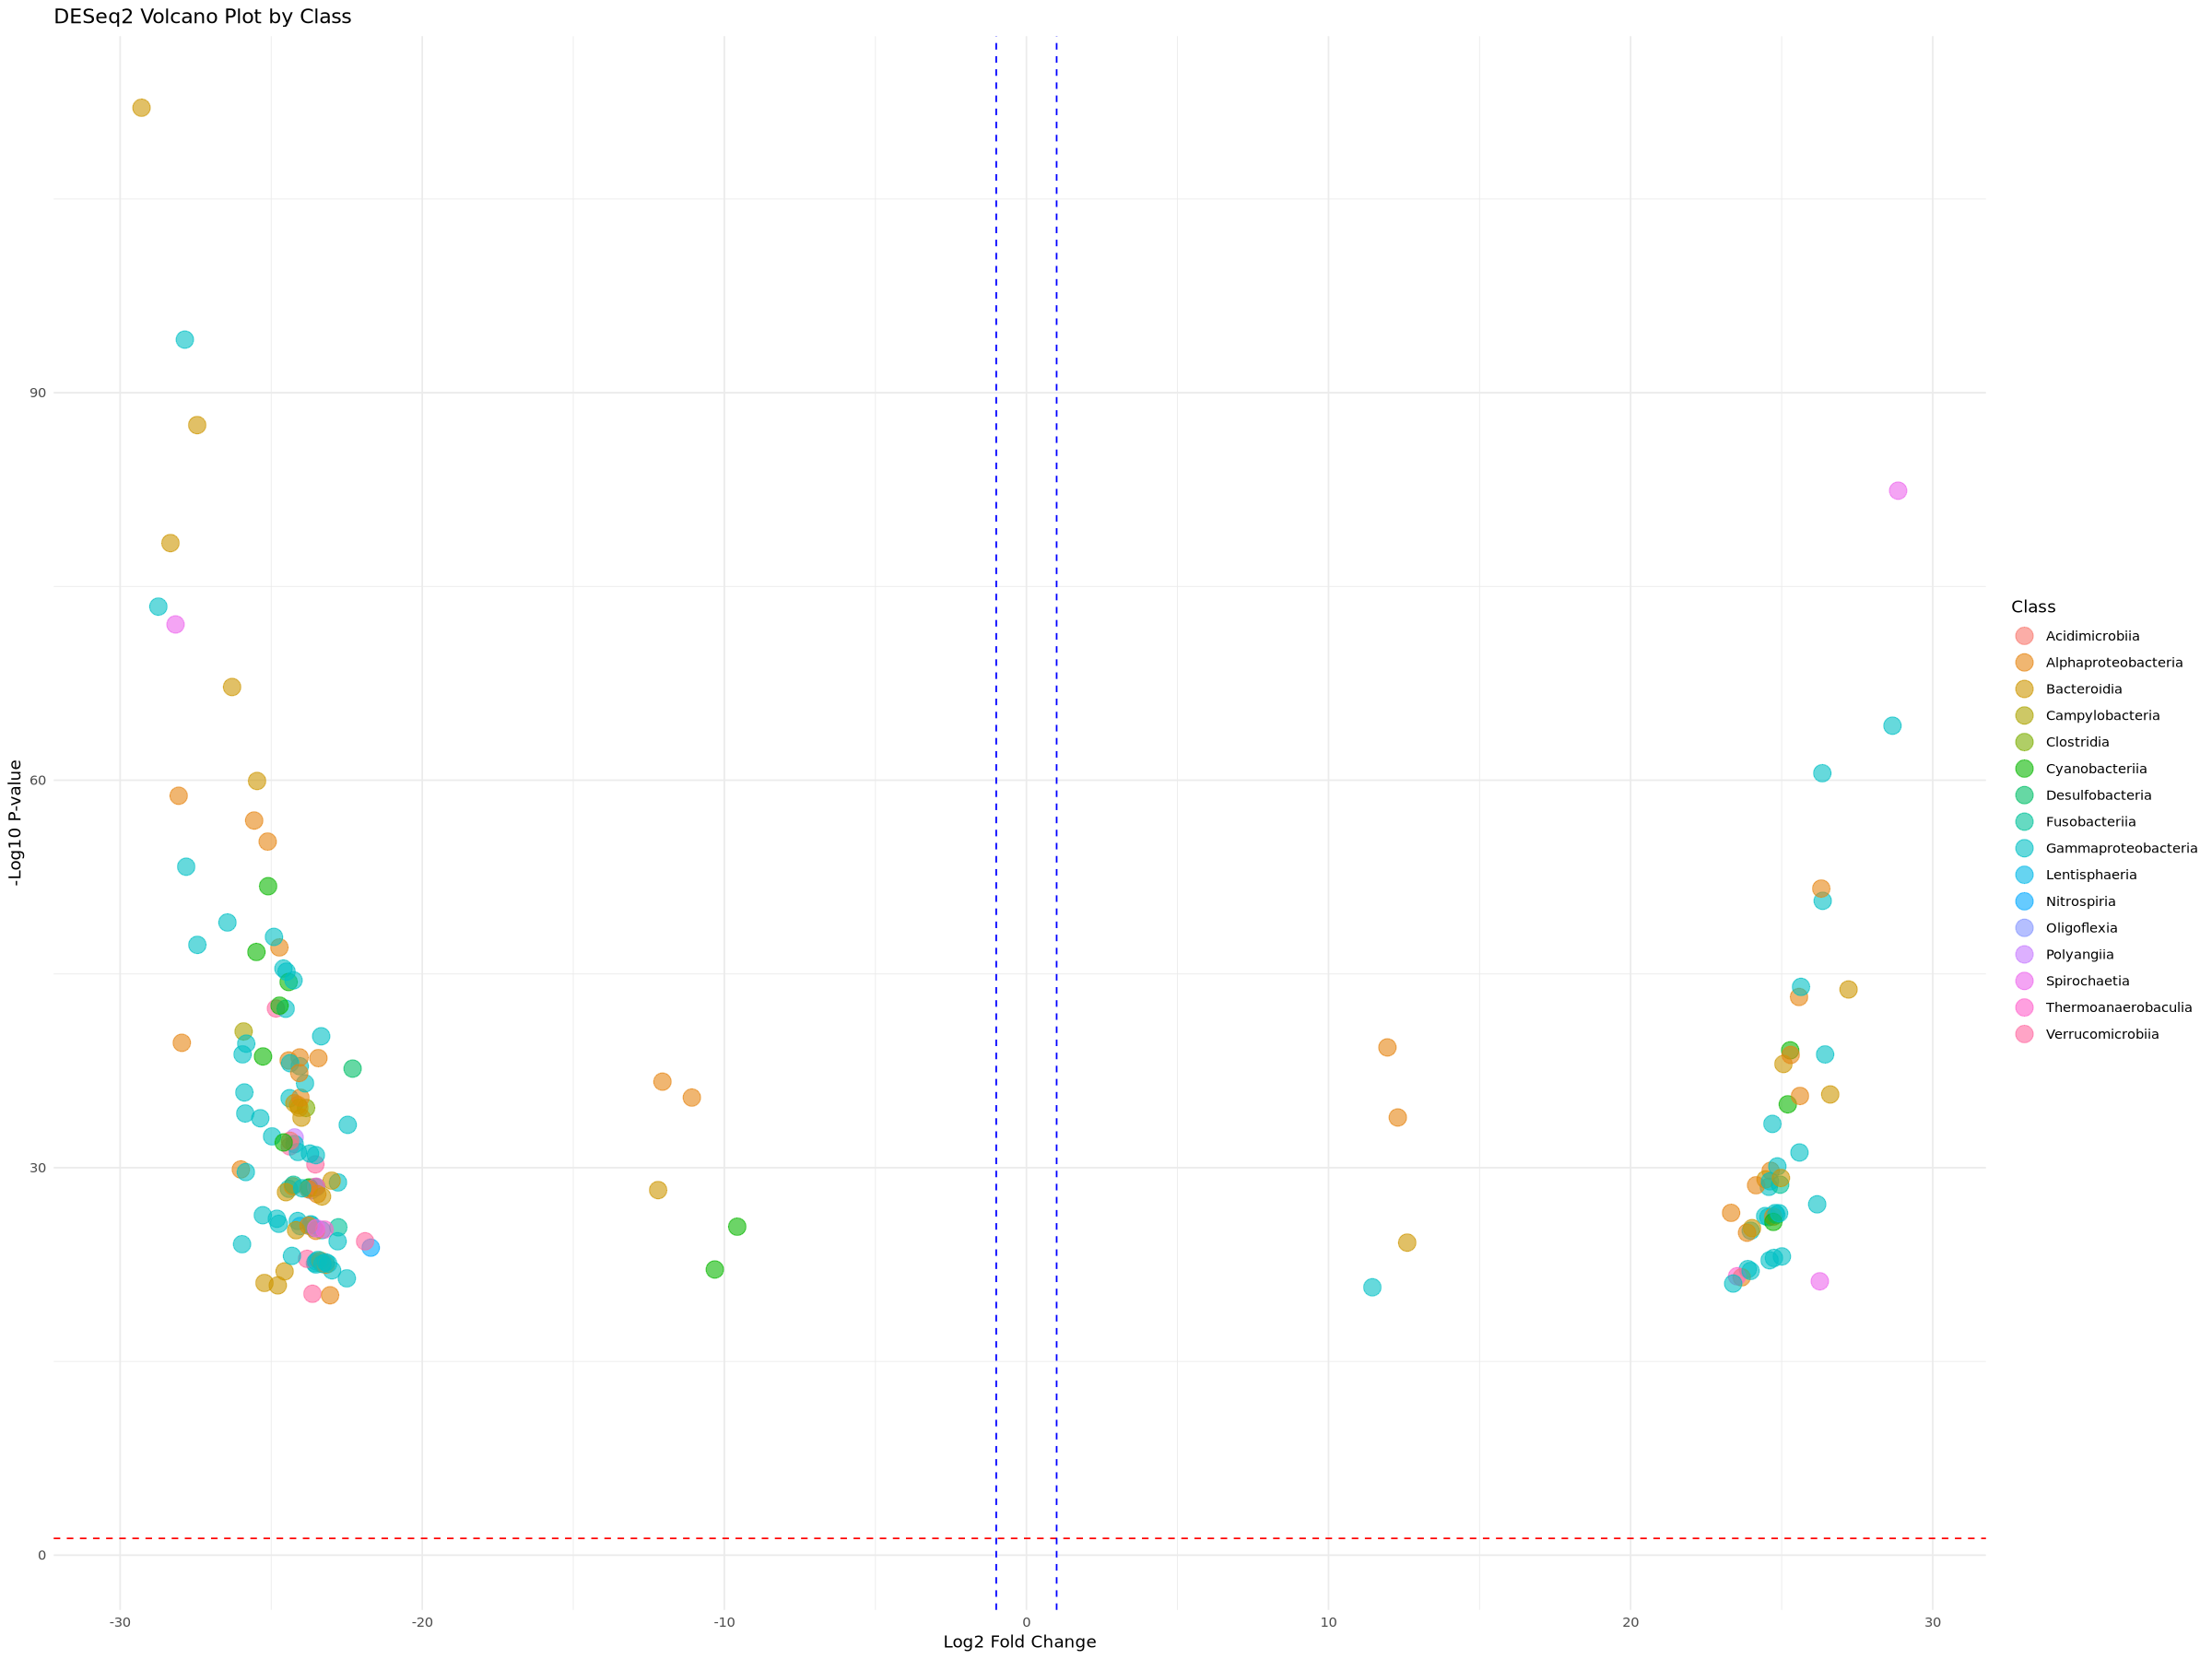

In [74]:
ggplot(taxa_sig_asvs, aes(x = log2FoldChange, y = -log10(pvalue))) +
  geom_point(aes(color = Class), alpha = 0.6, size = 5) +
  labs(title = "DESeq2 Volcano Plot by Class",
       x = "Log2 Fold Change",
       y = "-Log10 P-value",
       color = "Class") +
  theme_minimal() +
  # Add lines for significance and fold change thresholds
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "red") +
  geom_vline(xintercept = c(-1, 1), linetype = "dashed", color = "blue")

### Heatmap

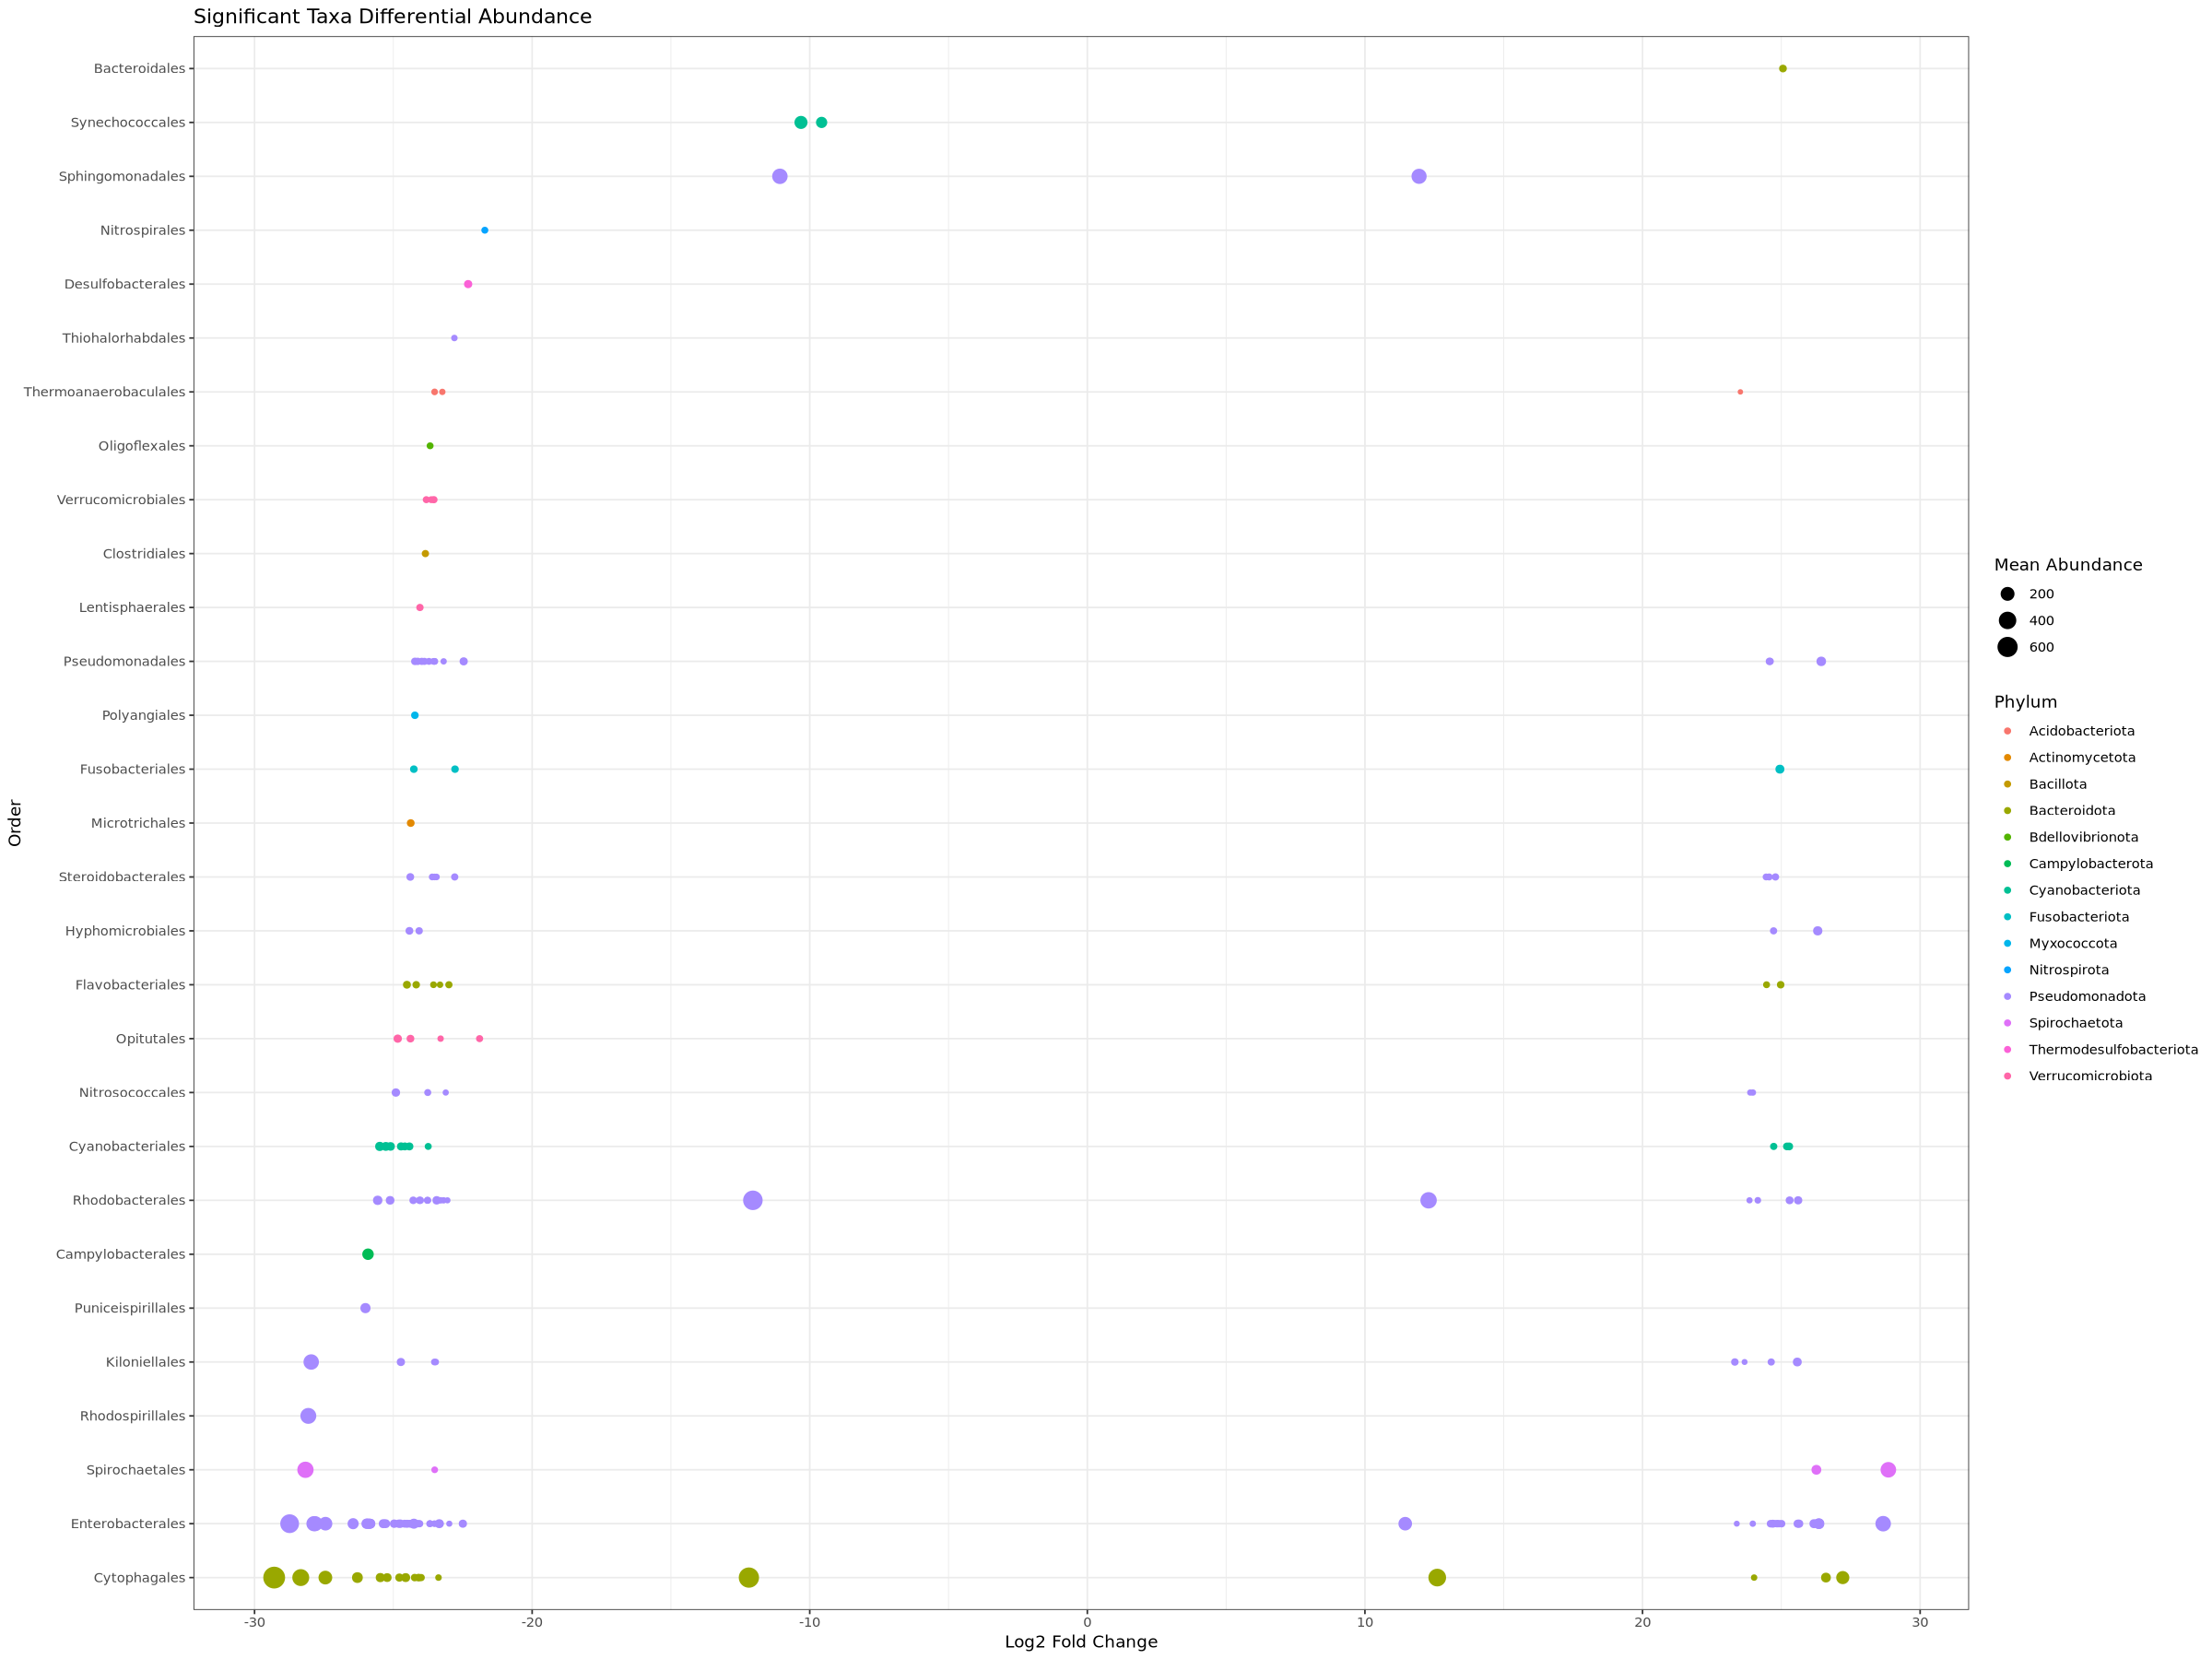

In [72]:

# Filter for significant results (e.g., adjusted p-value < 0.05 and |LFC| > 1)
sig_taxa <- subset(taxa_sig_asvs, padj < 0.001 & abs(log2FoldChange) > 1.5)

# Order taxa for plotting
sig_taxa$Order <- factor(sig_taxa$Order, levels = unique(sig_taxa$Order[order(sig_taxa$log2FoldChange)]))

ggplot(sig_taxa, aes(x = log2FoldChange, y = Order)) +
  geom_point(aes(size = baseMean, color = Phylum)) +
  labs(title = "Significant Taxa Differential Abundance",
       x = "Log2 Fold Change",
       y = "Order",
       size = "Mean Abundance",
       color = "Phylum") +
  theme_bw()

In [ ]:
library(pheatmap)

### what does this plot do??

In [ ]:
scale_fill_discrete <- function(palname = "Set3", ...) {
    scale_fill_brewer(palette = palname, ...)
}
# Phylum order
x = tapply(sig_cluster$log2FoldChange, sig_cluster$Phylum, function(x) max(x))
x = sort(x, TRUE)
sig_cluster$Phylum = factor(as.character(sig_cluster$Phylum), levels=names(x))
# Genus order
x = tapply(sig_cluster$log2FoldChange, sig_cluster$Family, function(x) max(x))
x = sort(x, TRUE)
sig_cluster$Family = factor(as.character(sig_cluster$Family), levels=names(x))
ggplot(sig_cluster, aes(x=Family, y=log2FoldChange, color=Phylum)) + geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))